In [1]:
import random
import os
import numpy as np
import torch

def seed_everything(seed):
    """
    """
    # 1. Python & Numpy
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    # 2. PyTorch (CPU & GPU)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"🔒 Locked Random Seed: {seed}")



In [2]:
import torch
import numpy as np
import random

def seed_everything_random():
    """
    Tạo random seed, set seed đó, và return seed để bạn biết
    """
    # Tạo random seed
    random_seed = random.randint(0, 999999)

    # Set seed
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    # Để reproducible
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    return random_seed


In [3]:
#import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc
from preprocess import get_sampler

def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
#load data
df_men = pd.read_csv(r"C:\Users\Lenovo\Documents\Neu 2025-2026\Lab\Hillstrom-Men.csv")
df_men = df_men.drop(columns="Unnamed: 0")
print ("---------------------------")
print ("null count:")
print (df_men.isnull().sum())
print ("---------------------------")
print(df_men.dtypes)
print ("---------------------------")
print ("labels:")
print(df_men.columns.tolist())
print ("---------------------------")
print("data shape:")
print(df_men.shape)


---------------------------
null count:
recency            0
history_segment    0
history            0
mens               0
womens             0
zip_code           0
newbie             0
channel            0
visit              0
conversion         0
spend              0
treatment          0
dtype: int64
---------------------------
recency              int64
history_segment     object
history            float64
mens                 int64
womens               int64
zip_code            object
newbie               int64
channel             object
visit                int64
conversion           int64
spend              float64
treatment            int64
dtype: object
---------------------------
labels:
['recency', 'history_segment', 'history', 'mens', 'womens', 'zip_code', 'newbie', 'channel', 'visit', 'conversion', 'spend', 'treatment']
---------------------------
data shape:
(42613, 12)


In [ ]:
#Hillstrom-men
#split num and cate
cate_cols = ['zip_code', 'channel']
num_cols = ['recency', 'history_segment', 'history']
#split x y t
y_men = df_men["spend"]
t_men = df_men["treatment"]
x_men = df_men.drop(columns=["spend", "treatment", "visit", "conversion"])

# x_men_encode = pd.get_dummies(x_men, columns=cate_cols, drop_first=True)
# x_men_encode = x_men_encode.astype(float)

#train test split - stratify CHỈ bằng treatment
x_men_train, x_men_test, t_men_train, t_men_test, y_men_train, y_men_test = train_test_split(
    x_men, t_men.values, y_men.values,
    test_size=0.3, random_state=42, stratify= t_men
)

# Tạo stratify cho val split - chỉ dùng treatment
stratify_var_train = pd.Series(t_men_train)

x_men_train, x_men_val, t_men_train, t_men_val, y_men_train, y_men_val = train_test_split(
    x_men_train, t_men_train, y_men_train,
    test_size=(1/7), random_state=42, stratify= t_men_train
)

# Fit get_dummies trên train, sau đó align với val/test
x_men_train_encode = pd.get_dummies(x_men_train, columns=cate_cols, drop_first=True)
x_men_val_encode = pd.get_dummies(x_men_val, columns=cate_cols, drop_first=True)
x_men_test_encode = pd.get_dummies(x_men_test, columns=cate_cols, drop_first=True)

# Align columns
x_men_val_encode = x_men_val_encode.reindex(columns=x_men_train_encode.columns, fill_value=0)
x_men_test_encode = x_men_test_encode.reindex(columns=x_men_train_encode.columns, fill_value=0)

scaler = StandardScaler()
x_men_train= scaler.fit_transform(x_men_train_encode)
x_men_val = scaler.transform(x_men_val_encode)
x_men_test = scaler.transform(x_men_test_encode)

print ("✅ Train/Val/Test split with stratification ONLY by treatment (NO DATA LEAKAGE)")
print (f"Train: {x_men_train.shape}, Val: {x_men_val.shape}, Test: {x_men_test.shape}")
print (f"Treatment distribution - Train: {np.mean(t_men_train):.2%}, Val: {np.mean(t_men_val):.2%}, Test: {np.mean(t_men_test):.2%}")
print (f"Spend mean - Train: {np.mean(y_men_train):.2f}, Val: {np.mean(y_men_val):.2f}, Test: {np.mean(y_men_test):.2f}")

# x_men = pd.DataFrame(x_men_train)
x_men_train

[[ 8.  4.  1.  0.  0.  0.  0.  1.  0.]
 [ 8.  1.  0.  1.  0.  0.  0.  1.  0.]
 [11.  2.  0.  1.  1.  0.  1.  1.  0.]]
[0. 0. 0. 0. 0.]


In [6]:
#Transform to tensor
def to_tensor(df):
    return torch.tensor(df, dtype=torch.float32)

x_men_train_t = to_tensor(x_men_train)
x_men_val_t = to_tensor(x_men_val)
x_men_test_t = to_tensor(x_men_test)

y_men_train_t = to_tensor(y_men_train).unsqueeze(1)
y_men_val_t = to_tensor(y_men_val).unsqueeze(1)
y_men_test_t = to_tensor(y_men_test).unsqueeze(1)

t_men_train_t = to_tensor(t_men_train.astype(float)).unsqueeze(1)
t_men_val_t = to_tensor(t_men_val.astype(float)).unsqueeze(1)
t_men_test_t = to_tensor(t_men_test.astype(float)).unsqueeze(1)

# sampler = get_sampler(y_men_train_t, target_positive_ratio=0.2)

#Data loader
train_dataset = TensorDataset(x_men_train_t, t_men_train_t, y_men_train_t)
val_dataset = TensorDataset(x_men_val_t, t_men_val_t, y_men_val_t)
test_dataset = TensorDataset(x_men_test_t, t_men_test_t, y_men_test_t)

batch_size = 6400
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print ("-------------------------------------------------------------")
print ("✅Completed tranform to tensor✅")
print (f"Shape of train: x={x_men_train_t.shape}; y ={y_men_train_t.shape}; t={t_men_train_t.shape}")
print (f"Shape of val: x={x_men_val_t.shape}; y={y_men_val_t.shape}; t={t_men_val_t.shape}")
print (f"Shape of test: x={x_men_test_t.shape}; y={y_men_test_t.shape}; t={t_men_test_t.shape}")

-------------------------------------------------------------
✅Completed tranform to tensor✅
Shape of train: x=torch.Size([25567, 9]); y =torch.Size([25567, 1]); t=torch.Size([25567, 1])
Shape of val: x=torch.Size([4261, 9]); y=torch.Size([4261, 1]); t=torch.Size([4261, 1])
Shape of test: x=torch.Size([12785, 9]); y=torch.Size([12785, 1]); t=torch.Size([12785, 1])


In [7]:
from metrics import auuc, auqc, lift, krcc

In [8]:
from dragonnet import Dragonnet

In [9]:
print("📊 Data Distribution Check:")
print(f"Y train: mean={y_men_train.mean():.4f}, std={y_men_train.std():.4f}")
print(f"Y train zeros: {(y_men_train == 0).sum()} / {len(y_men_train)} ({(y_men_train == 0).sum()/len(y_men_train)*100:.1f}%)")
print(f"\nTreatment balance:")
print(f"  Train: {(t_men_train == 1).sum()} treated, {(t_men_train == 0).sum()} control")
print(f"  Test:  {(t_men_test == 1).sum()} treated, {(t_men_test == 0).sum()} control")

📊 Data Distribution Check:
Y train: mean=1.0188, std=14.8554
Y train zeros: 25342 / 25567 (99.1%)

Treatment balance:
  Train: 12784 treated, 12783 control
  Test:  6392 treated, 6393 control


In [10]:
seed = 42
seed_everything(seed)

🔒 Locked Random Seed: 42


In [11]:

# seed = seed_everything_random()
# print(f"Using seed: {seed}")

# # ... chạy training code của bạn ...

# # Sau khi chạy xong, bạn biết seed là bao nhiêu
# print(f"Experiment completed with seed: {seed}")

In [12]:
clear_memory()
epochs = 1000
alpha = 5e-3
beta = 1e-3
lr = 2e-5
weight_decay = 1e-5
response_lambda = 0
uplift_lambda = 0
shared_hidden = 200
outcome_hidden = 100
tarreg_start = 450
print (f" epochs = {epochs}")
print (f" alpha = {alpha}")
print (f" beta = {beta}")
print (f" learning rate = {lr}")
print (f" weight decay = {weight_decay}")
print (f" batch size = {batch_size}")
dragonnet = Dragonnet(input_dim=x_men_train.shape[1], epochs=epochs, alpha = alpha, beta = beta, learning_rate=lr, weight_decay=weight_decay, outcome_hidden=outcome_hidden, shared_hidden=shared_hidden, early_stop_metric="loss", tarrreg_start_epoch=tarreg_start)
dragonnet.fit(train_loader, val_loader)

print ("Complete training")

 epochs = 1000
 alpha = 0.005
 beta = 0.001
 batch size = 6400
🔃🔃🔃Begin training Dragonnet🔃🔃🔃
Epoch 5 | Base Loss: 0.8630 | Tarreg Loss: 0.000000 | Total Loss: 0.8630
Epoch 10 | Base Loss: 0.8625 | Tarreg Loss: 0.000000 | Total Loss: 0.8625
Epoch 15 | Base Loss: 0.8332 | Tarreg Loss: 0.000000 | Total Loss: 0.8332
Epoch 20 | Base Loss: 0.8078 | Tarreg Loss: 0.000000 | Total Loss: 0.8078
Epoch 25 | Base Loss: 0.7570 | Tarreg Loss: 0.000000 | Total Loss: 0.7570
Epoch 30 | Base Loss: 0.6908 | Tarreg Loss: 0.000000 | Total Loss: 0.6908
Epoch 35 | Base Loss: 0.6303 | Tarreg Loss: 0.000000 | Total Loss: 0.6303
Epoch 40 | Base Loss: 0.5536 | Tarreg Loss: 0.000000 | Total Loss: 0.5536
Epoch 45 | Base Loss: 0.4640 | Tarreg Loss: 0.000000 | Total Loss: 0.4640
Epoch 50 | Base Loss: 0.3644 | Tarreg Loss: 0.000000 | Total Loss: 0.3644
Epoch 55 | Base Loss: 0.2788 | Tarreg Loss: 0.000000 | Total Loss: 0.2788
Epoch 60 | Base Loss: 0.2032 | Tarreg Loss: 0.000000 | Total Loss: 0.2032
Epoch 65 | Base Los

KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_test_subset = x_men_test_t.to(device)
y0_pred, y1_pred, t_pred, _ = dragonnet.predict(x_test_subset)


uplift_dollars = y1_pred - y0_pred

print("\n📊 Model Output Check:")
print(f"y0_pred: min={y0_pred.min():.4f}, max={y0_pred.max():.4f}, mean={y0_pred.mean():.4f}")
print(f"y1_pred: min={y1_pred.min():.4f}, max={y1_pred.max():.4f}, mean={y1_pred.mean():.4f}")
print(f"t_pred:  min={t_pred.min():.4f}, max={t_pred.max():.4f}, mean={t_pred.mean():.4f}")

uplift = (y1_pred - y0_pred)
print(f"Uplift:  min={uplift.min():.4f}, max={uplift.max():.4f}, std={uplift.std():.4f}")

if uplift.std() < 0.01:
    print("⚠️ WARNING: Model is predicting almost constant uplift!")


📊 Model Output Check:
y0_pred: min=1.7085, max=415.3673, mean=9.8361
y1_pred: min=3.0491, max=36.8382, mean=8.1070
t_pred:  min=0.4498, max=0.4981, mean=0.4753
Uplift:  min=-378.5291, max=2.1917, std=8.4147


c:\Users\Lenovo\Documents\Neu 2025-2026\Lab\RERUM\dragonnet.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32, device=self.device)


Evaluating baseline🔃🔃🔃


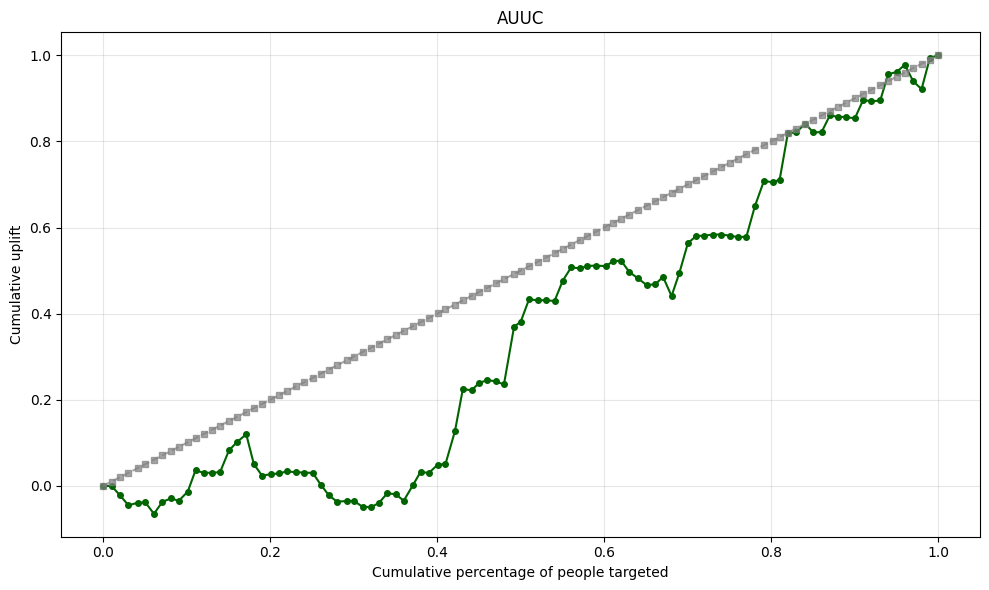

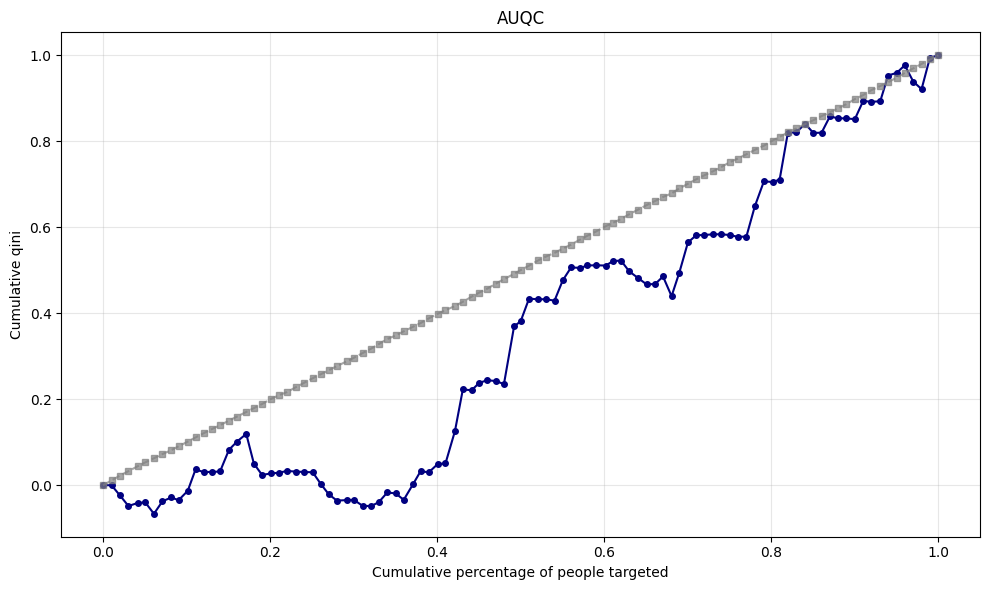

----------------------------------------
AUUC:  0.3545736534588821
AUQC:  0.3540714065865098
Lift:  -0.09288358688354492
KRCC:  -0.10123974582015952
seed: 42


In [ ]:
print ("Evaluating baseline🔃🔃🔃")
# Ensure the input tensor is on the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_men_test_t_on_device = x_men_test_t.to(device)

y0_pred, y1_pred, _,_ = dragonnet.predict(x_men_test_t_on_device)

# Move predicted tensors back to CPU before converting to numpy arrays
uplift_pred = (y1_pred - y0_pred).cpu().numpy().flatten()

y_true = y_men_test_t.cpu().numpy().flatten() # Ensure true labels are also on CPU if they were ever moved
t_true = t_men_test_t.cpu().numpy().flatten() # Ensure true treatments are also on CPU if they were ever moved

auuc_score = auuc(y_true, t_true, uplift_pred, bins=100, plot=True)
auqc_score = auqc(y_true, t_true, uplift_pred, bins=100, plot=True)
lift_score = lift(y_true, t_true, uplift_pred, h=0.3)
krcc_score = krcc(y_true, t_true, uplift_pred, bins= 100)

print ("-"*40)
print (f"AUUC: {auuc_score:.3f}")
print (f"AUQC: {auqc_score:.3f}")
print (f"Lift: {lift_score:.3f}")
print (f"KRCC: {krcc_score:.3f}")
print (f"seed: {seed}")